# Computer Vision Foundation: LeNet Model

![lenet.png](lenet.png)

[LeCun98]	LeCun, Y., Bottou, L., Bengio, Y., and Haffner, P. (1998d). Gradient-based learning applied to document recognition. Proceedings of the IEEE, 86(11), 2278–2324.

# LeNet-5: Origin of ConvNet 

LeNet-5, a pioneering 7-level convolutional network by LeCun et al. in 1998, that classifies digits, was applied by several banks to recognize hand-written numbers on checks digitized in 32x32 pixel images. The ability to process higher resolution images requires larger and more layers of convolutional neural networks, so this technique is constrained by the availability of computing resources. Lenet model origin rooted in Fukushima’s Neocognitron. LeCun proposed a supervised training of ConvNet using the backpropagation algorithm. 


Due to the good performance of CNN in optical character and fingerprint recognition, its commercial use in ATM and Banks started in 1993 and 1996, respectively. In this era, LeNet-5 achieved many successful milestones for optical character recognition tasks, but it didn’t perform well on other image recognition problems [	arXiv:2003.11066]

In this notebook, I will try to recreate LeNet model using tensorflow.keras and interrogate the model under different conditions. Then I will apply the same model structure to Cifar-10 data and evaluate the results.




### LeNet-5 Network Structure:
1. Convolution #1. Input = 32x32x1. Output = 28x28x6 conv2d
2. SubSampling #1. Input = 28x28x6. Output = 14x14x6. SubSampling is simply Average Pooling so we use avg_pool
3. Convolution #2. Input = 14x14x6. Output = 10x10x16 conv2d
4. SubSampling #2. Input = 10x10x16. Output = 5x5x16 avg_pool
5. Fully Connected #1. Input = 5x5x16. Output = 120
6. Fully Connected #2. Input = 120. Output = 84
7. Output 10

### Dataset: MNIST

# A) Data Download

In [2]:
from requests import get
def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

In [3]:
# Dataset Names
ImageTrain='train-images-idx3-ubyte.gz'
LabelTrain='train-labels-idx1-ubyte.gz'
ImageTest='t10k-images-idx3-ubyte.gz'
LabelTest='t10k-labels-idx1-ubyte.gz'

In [4]:
download_file('http://yann.lecun.com/exdb/mnist/'+ImageTrain, ImageTrain)
download_file('http://yann.lecun.com/exdb/mnist/'+LabelTrain, LabelTrain)
download_file('http://yann.lecun.com/exdb/mnist/'+ImageTest,ImageTest )
download_file('http://yann.lecun.com/exdb/mnist/'+LabelTest,LabelTest )

In [1]:
import gzip
import numpy as np
import pandas as pd
from time import time
import datetime
from sklearn.model_selection import train_test_split

import tensorflow as tf
#import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [3]:
print('Tensorflow version: ',tf.__version__)

Tensorflow version:  2.3.1


In [4]:
def DataProcessing(ImageTrain, LabelTrain, ImageTest, LabelTest, Normalize):
    """
    This function processes the data:
    reads images from zip file
    using train_test_split, splits the data into train, test, and validation
    add padding to the images to create 32 * 32 images
    normalizes the data by dividing to 255
    
    requires:
    ImageTrain - zip file containing downloaded train images
    LabelTrain - zip file containing label of downloaded train images
    ImageTest  - zip file containing downloaded test images
    LabelTest  - zip file containing label of downloaded test images
    AddPad     - if true it will add padding to the images  
    PadLength  - if AddPad= True then padding of the length PadLength will be added to images
    Normalize  - if True it will normalize images to 255
    """
    train = {};test = {};
    # ---
    # Reading Training Labels
    with gzip.open(LabelTrain, 'rb') as labelsFile:
        train['labels'] = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)
    # Reading Training Images
    with gzip.open(ImageTrain ,'rb') as imagesFile:
        length = len(train['labels'])
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        train['features'] = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)   
    # ---
    # Reading Test Labels
    with gzip.open(LabelTest, 'rb') as labelsFile:
        test['labels'] = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)
    # Reading Test Images
    with gzip.open(ImageTest ,'rb') as imagesFile:
        length = len(test['labels'])
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        test['features'] = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1) 
    validation = {}
    train['features'], validation['features'], train['labels'], validation['labels'] =\
                    train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

    print('Shape of training features data:        ', train['features'].shape)
    print('Shape of training labels data:          ', train['labels'].shape)
    print('Shape of test features data:            ', test['features'].shape)
    print('Shape of test labels data:              ', test['labels'].shape)
    print('Shape of validation features data:      ', validation['features'].shape)
    print('Shape of validation labels data:        ', validation['labels'].shape)
    #---
    if Normalize:
        print('--> Data is normalized')
        train['features']=np.divide(train['features'],255)
        test['features']=np.divide(test['features'],255)
        validation['features']=np.divide(validation['features'],255)

    return train,test,validation

In [5]:
train,test,validation=DataProcessing(ImageTrain,LabelTrain,ImageTest,LabelTest,True)

Shape of training features data:         (48000, 28, 28, 1)
Shape of training labels data:           (48000,)
Shape of test features data:             (10000, 28, 28, 1)
Shape of test labels data:               (10000,)
Shape of validation features data:       (12000, 28, 28, 1)
Shape of validation labels data:         (12000,)
--> Data is normalized


First lets explore the labels:

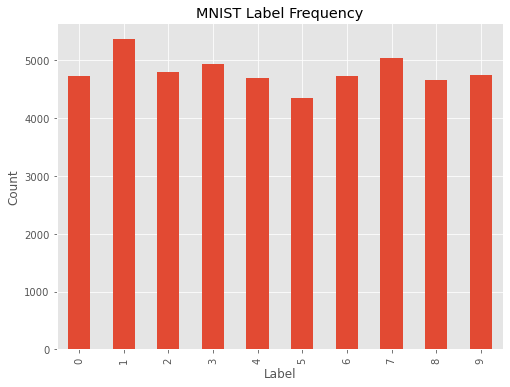

In [6]:
Nclasses=len(np.unique(train['labels']))
pd.DataFrame(np.transpose(np.unique(train['labels'], \
                                    return_counts=True)),columns=['Label','Count']).plot(x='Label',\
                                         y='Count',kind='bar',legend=False,figsize=(8,6));
plt.ylabel('Count');
plt.title('MNIST Label Frequency');
plt.savefig('MNIST_Label_Frequency.png', bbox_inches='tight',dpi=300)

In [7]:
def display_image(position,saveFig):
    """
    This function plots selected MNIST image
    requires:
    position - selected index number of the image list of 4 indecies
    saveFig - if true, image will be saved to the hard disk
    """
    fig,ax=plt.subplots(nrows=2,ncols=2,figsize=(10,8))
    
    image = train['features'][position[0]].squeeze()
    ax[0,0].set_title('Label: %d' % (train['labels'][position[0]]))
    ax[0,0].imshow(image, cmap=plt.cm.gray_r)
    ax[0,0].set_axis_off()
    image = train['features'][position[1]].squeeze()
    ax[0,1].set_title('Label: %d' % (train['labels'][position[1]]))
    ax[0,1].imshow(image, cmap=plt.cm.gray_r)
    ax[0,1].set_axis_off()
    image = train['features'][position[2]].squeeze()
    ax[1,0].set_title('Label: %d' % (train['labels'][position[2]]))
    ax[1,0].imshow(image, cmap=plt.cm.gray_r)
    ax[1,0].set_axis_off()
    image = train['features'][position[3]].squeeze()
    ax[1,1].set_title('Label: %d' % (train['labels'][position[3]]))
    ax[1,1].imshow(image, cmap=plt.cm.gray_r)
    ax[1,1].set_axis_off()
    fig.tight_layout(pad=0)
    if saveFig:
        plt.savefig('Example_'+str(position)+'.png', bbox_inches='tight',dpi=50)

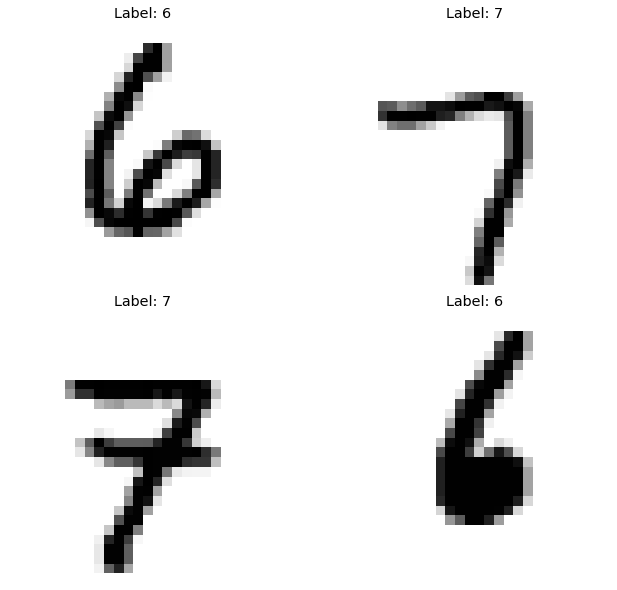

In [8]:
display_image([110,3,5,113],True)

# B) Model Training

Function ModelBuildTrain builds the model, trains the model, and plots the learning curves.    

In [10]:
def ModelBuildTrain(input_shape, Nclasses,ActivationFunc,Pooling,Optimizer,\
                train,test,validation,epochs, batch_size,verbose,\
                modelName,modelSaveName,saveFig,save_path,showfigs):
    """
    This function builds, trains and plots the learning curve of the trained model
    """
        
    def ModelBuilder(input_shape, Nclasses,ActivationFunc,Pooling,Optimizer):
        """
        ModelBuilder builds variety of 5 layer sequential models
        requires:
        input_shape     - Input shape of the data 
        Nclasses        - Number of classes in the data (10 labels in case of MNIST)
        ActivationFunc  - ActivationFunc of layers execpt the final layer
        Pooling         - Pooling layer type (A)AvgPool is used in original LeNet model, (B) MaxPool
        Optimizer       - choices between sgd and adam optimzier
        """
        model = Sequential()
        # Layer 1 Conv2D
        model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation=ActivationFunc, input_shape=input_shape, padding="same"))
        # Layer 2 Pooling Layer
        if Pooling=='AvgPool':
            model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        else:
            model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))   
        # Layer 3 Conv2D
        model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation=ActivationFunc, padding='valid'))
        # Layer 4 Pooling Layer
        if Pooling=='AvgPool':
            model.add(layers.AveragePooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
        else:
            model.add(layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))    
        model.add(layers.Flatten())
        model.add(layers.Dense(units=120, activation=ActivationFunc))
        model.add(layers.Dense(units=84, activation=ActivationFunc))
        model.add(layers.Dense(units=Nclasses, activation='softmax'))
        if Optimizer=='adam':
            model.compile(optimizer='adam',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])
        elif Optimizer=='sgd':
            model.compile(optimizer='sgd',loss=tf.keras.losses.categorical_crossentropy,metrics=['accuracy'])
        return model
    
    def ModelTrain(model,train,test,validation,epochs, batch_size,verbose):
        """ 
        This function trains the model
        requires:
        model       -  compiled model from ModelBuilder function
        train       -  training data including training features and labels
        test        -  testing data including testing features and labels
        validation  -  validation data including validation features and labels
        epochs      -  total number of epochs
        batch_size  -  batch size
        verbose     -  if 1 tensorflow will print model evaluation at the end of each epoch
        """
        print('Starting model training')
        start_time = time()
        history=model.fit(x= train['features'], y=to_categorical(train['labels']), epochs=epochs,batch_size=batch_size,\
                         validation_data=(validation['features'], to_categorical(validation['labels'])),\
                        verbose=verbose)
        end_time= time()
        training_time=np.round((end_time-start_time)/60,2)
        print('Finished model training in ',training_time,'(minutes)')
        testloss, testacc = model.evaluate( test['features'], to_categorical(test['labels']), \
                                           batch_size=batch_size,verbose=verbose)
        metrics={}
        metrics['TestAccuracy']=testacc
        metrics['TestLoss']=testloss
        print('Test Accuracy: ',testacc)
        return model,metrics,history,training_time
    
    def PlotHistory(history,modelName,modelSaveName,saveFig, save_path, showfigs):
        """
        Utility function to plot learning curves
        requires:
        history       - Pandas dataframe containing learning loss/accuracy per epochs for both train and validation
        modelName     - Model name for plot title
        modelSaveName - Model name for saving figure
        saveFig       - if True learning curves will be saved
        save_path     - save path of the images
        showfigs      - if true figures will be shown while training else no figure will be shown
        """
        hist=pd.DataFrame(history.history)
        hist['epoch']=history.epoch
        fig, (ax1, ax2)=plt.subplots(nrows=1,ncols=2,figsize=(9,6))
        # Loss
        fig.subplots_adjust(hspace=0.5)
        ax1.plot(hist['epoch'],hist['loss'],color='blue',label='Training Loss')
        #ax1.plot(hist['epoch'],hist['val_loss'],color='red',label='Validation Loss')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.set_title('Model: '+str(modelName),fontsize=15)
        # Accuracy
        ax2.plot(hist['epoch'],hist['accuracy'],color='blue',label='Training Accuracy')
        #ax2.plot(hist['epoch'],hist['val_accuracy'],color='red',label='Validation Accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.legend();
        ax2.set_title('Model: '+str(modelName),fontsize=15)
        if showfigs:
            plt.show();
        if saveFig:
            fig.savefig(save_path+'Learning_Curve_'+str(modelSaveName)+'.png',bbox_inches='tight',format='png',dpi=300)
            
    print('Building model')
    model=ModelBuilder(input_shape, Nclasses,ActivationFunc,Pooling,Optimizer);
    model,metrics,history,training_time=ModelTrain(model,train,test,validation,epochs, batch_size,verbose);
    PlotHistory(history,modelName,modelSaveName,saveFig, save_path, showfigs);
    return model,metrics,history,training_time

## Original LeNet-5 Model

Building model
Starting model training
Finished model training in  0.28 (minutes)
Test Accuracy:  0.9416999816894531


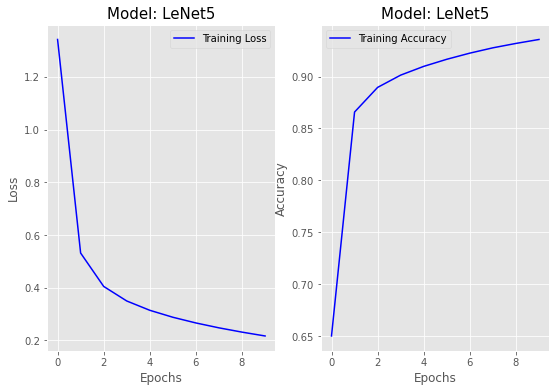

In [11]:
input_shape=train['features'][0].shape;
ActivationFunc='tanh';
Pooling='AvgPool';
Optimizer='sgd';
epochs=10;
batch_size=128;
verbose=0;
modelName='LeNet5'
modelSaveName='LeNet5_Optimizer_'+Optimizer
saveFig=True
showfigs=True
save_path='C:\\Users\\Shaleen\\Documents\\Visual Studio 2019\\Semester Project\\LeNet-5'

LeNet5_sgd,metrics_LeNet5_sgd,history_LeNet5_sgd,training_time_LeNet5_sgd=\
                                    ModelBuildTrain(input_shape, Nclasses,ActivationFunc,Pooling,Optimizer,\
                                    train,test,validation,epochs, batch_size,verbose,\
                                    modelName,modelSaveName,saveFig,save_path,showfigs)

### LeNet-5 Model Summary

In [12]:
LeNet5_sgd.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d (AveragePo (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_1 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               48120     
_________________________________________________________________
dense_1 (Dense)              (None, 84)                1

### LeNet-5 Optimizer Configuration

In [13]:
LeNet5_sgd.optimizer.get_config()

{'name': 'SGD',
 'learning_rate': 0.01,
 'decay': 0.0,
 'momentum': 0.0,
 'nesterov': False}

## Using Adam Optimizer

Building model
Starting model training
Finished model training in  0.22 (minutes)
Test Accuracy:  0.9854999780654907


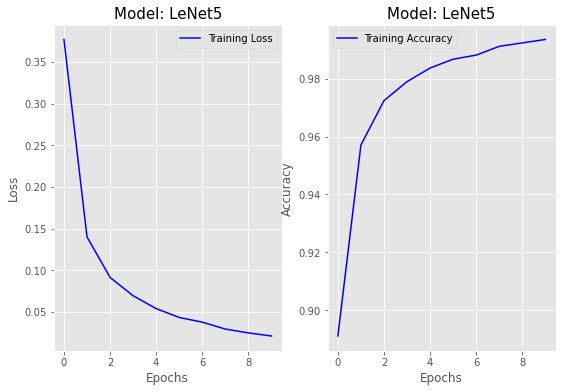

In [14]:
# Original LeNet-5 Model
input_shape=train['features'][0].shape;
ActivationFunc='tanh';
Pooling='AvgPool';
Optimizer='adam';
epochs=10;
batch_size=128;
verbose=0;
modelName='LeNet5'
modelSaveName='LeNet5_Optimizer_'+Optimizer
saveFig=True
showfigs=True
save_path='C:\\Users\\Shaleen\\Documents\\Visual Studio 2019\\Semester Project\\LeNet-5'

LeNet5_adam,metrics_LeNet5_adam,history_LeNet5_adam,training_time_LeNet5_adam=ModelBuildTrain(input_shape, Nclasses,ActivationFunc,Pooling,Optimizer,\
                                    train,test,validation,epochs, batch_size,verbose,\
                                    modelName,modelSaveName,saveFig,save_path,showfigs)

### LeNet-5 with Adam Optimizer Configuration

In [16]:
LeNet5_adam.optimizer.get_config()

{'name': 'Adam',
 'learning_rate': 0.001,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

## Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix
import itertools
confusion = confusion_matrix(test['labels'],\
                             np.argmax(LeNet5_sgd.predict(test['features']),axis=1),labels=list(np.arange(0,10)))

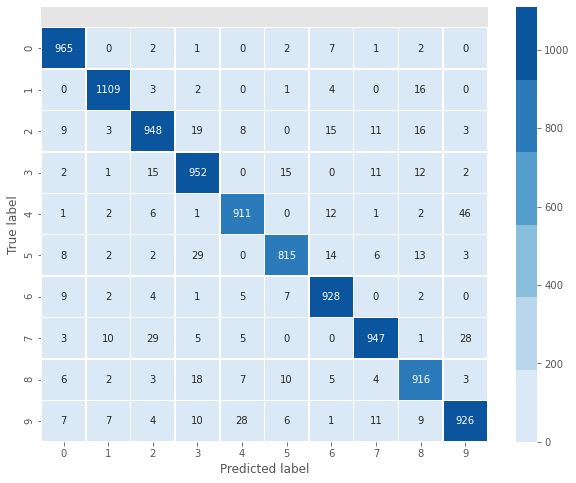

In [16]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(confusion, annot=True,ax=ax,fmt="d",linewidths=.5,cmap=sns.color_palette("Blues"));
plt.ylim([ 10,-0.5,]);
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('Confusion.png',bbox_inches='tight',format='png',dpi=150)

In [17]:
preds=pd.DataFrame(np.argmax(LeNet5_sgd.predict(test['features']),axis=1),columns=['Predicted'])
preds['Actual']=test['labels']

In [18]:
miss_classified=preds[(preds.Predicted==7) &(preds.Actual==2)].copy()

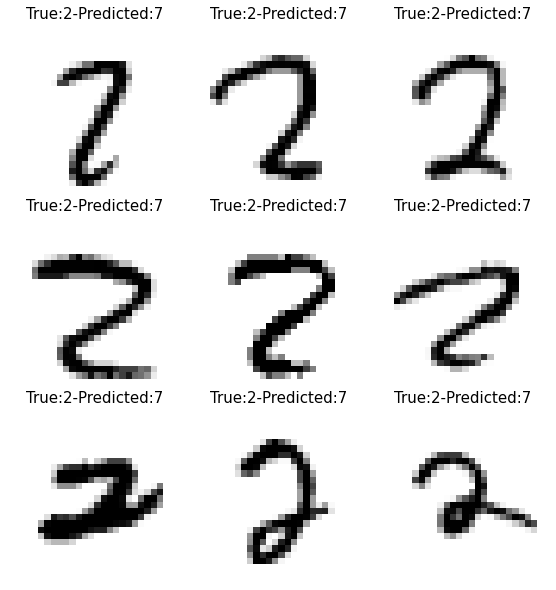

In [22]:
ncol=3
nrow=3
fig=plt.figure(figsize=(8,8))
for i in range(1, ncol*nrow +1):
        fig.add_subplot(nrow, ncol, i)
        plt.imshow(test['features'][miss_classified.index[i-1]].squeeze(), cmap=plt.cm.gray_r)
        plt.title('True:2-Predicted:7', fontsize=15)
        plt.axis('off')
        fig.tight_layout(pad=0)
plt.show()
fig.savefig('miss_classified.png',bbox_inches='tight',format='png',dpi=150)       

In [23]:
adam_sgd=(metrics_LeNet5_adam['TestAccuracy']-metrics_LeNet5_sgd['TestAccuracy'])*100/metrics_LeNet5_sgd['TestAccuracy']
print('Adam accuracy improvement over SGD: %',np.round(adam_sgd,1))

Adam accuracy improvement over SGD: % 4.4


# C) Effect of Batch Size

In [23]:
batch_sizes=2**np.array(range(2,12,))

--->Batch Size: 4
Building model
Starting model training
Finished model training in  3.84 (minutes)
Test Accuracy:  0.9855999946594238
--->Batch Size: 8
Building model
Starting model training
Finished model training in  1.84 (minutes)
Test Accuracy:  0.983299970626831
--->Batch Size: 16
Building model
Starting model training
Finished model training in  0.96 (minutes)
Test Accuracy:  0.9843999743461609
--->Batch Size: 32
Building model
Starting model training
Finished model training in  0.5 (minutes)
Test Accuracy:  0.9842000007629395
--->Batch Size: 64
Building model
Starting model training
Finished model training in  0.3 (minutes)
Test Accuracy:  0.9853000044822693
--->Batch Size: 128
Building model
Starting model training
Finished model training in  0.22 (minutes)
Test Accuracy:  0.9825999736785889
--->Batch Size: 256
Building model
Starting model training
Finished model training in  0.2 (minutes)
Test Accuracy:  0.9848999977111816
--->Batch Size: 512
Building model
Starting model tr

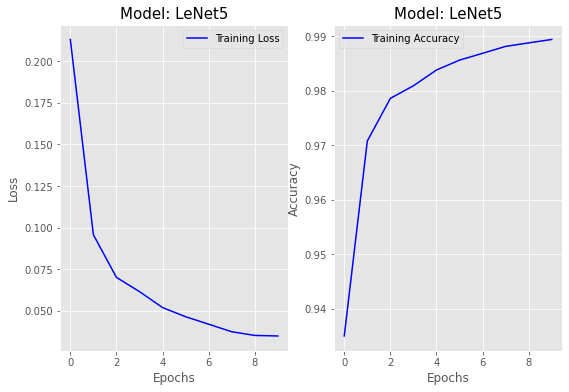

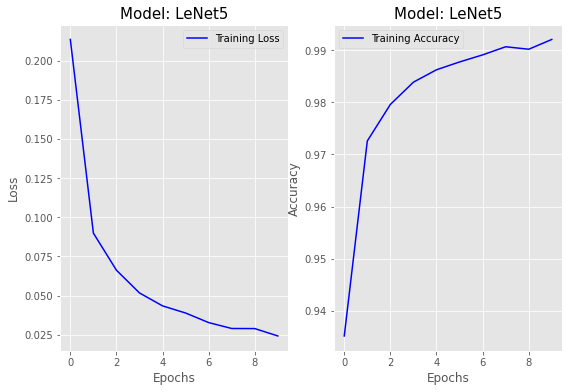

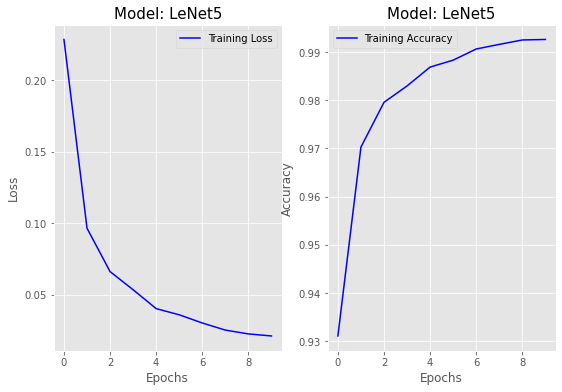

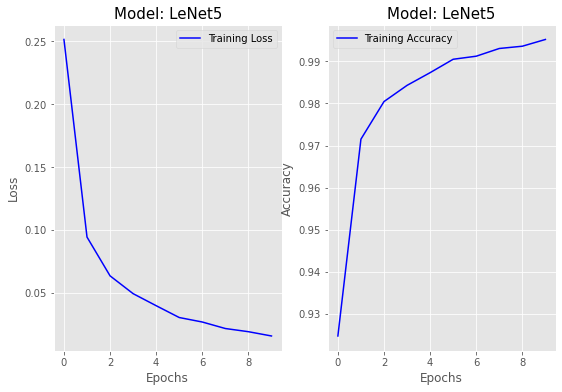

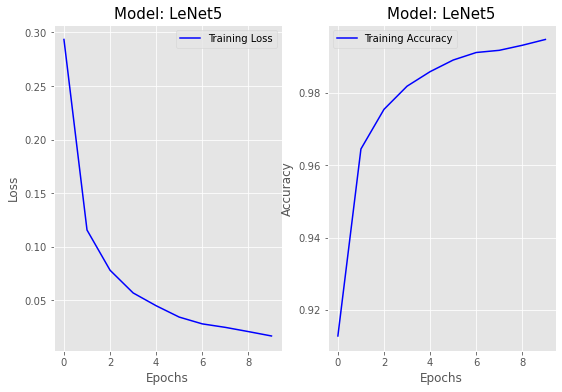

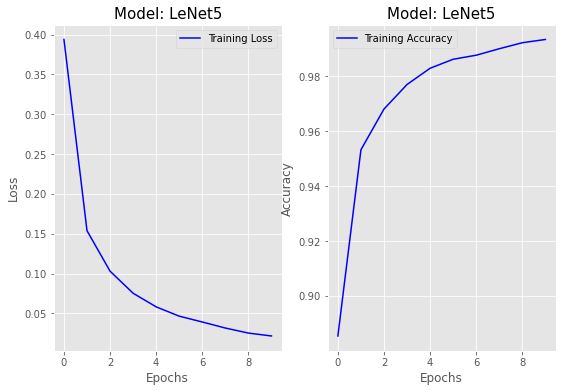

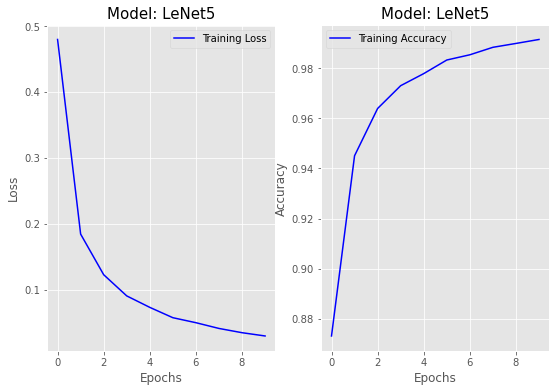

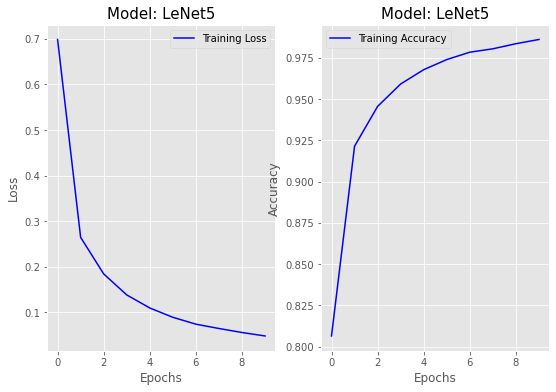

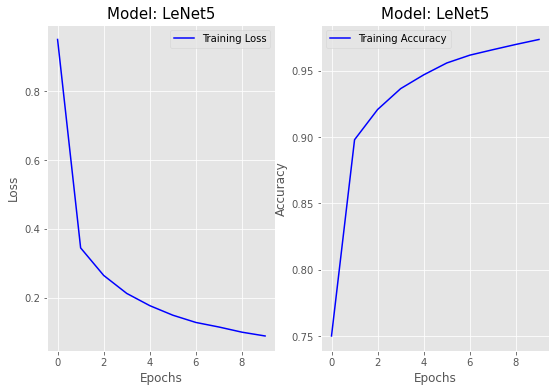

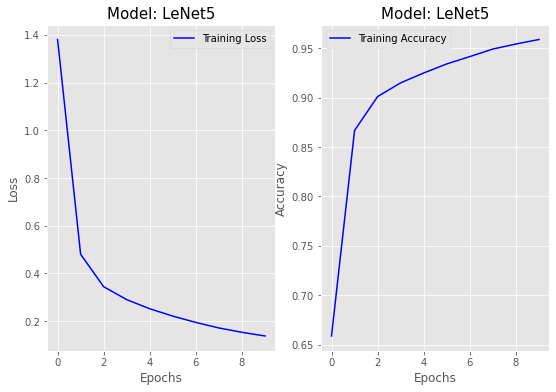

In [24]:
input_shape=train['features'][0].shape;
ActivationFunc='tanh';
Pooling='AvgPool';
Optimizer='adam';
epochs=10;
verbose=0;
modelName='LeNet5'
modelSaveName='LeNet5_Optimizer_'+Optimizer
saveFig=False
showfigs=False
save_path='C:\\Users\\Shaleen\\Documents\\Visual Studio 2019\\Semester Project\\LeNet-5'


metrics_all=[];training_time_all=[]; 
for batch_size in batch_sizes:
    print('--->Batch Size:',batch_size)
    _,metrics,_,training_time=ModelBuildTrain(input_shape, Nclasses,ActivationFunc,Pooling,Optimizer,\
                                    train,test,validation,epochs, batch_size,verbose,\
                                    modelName,modelSaveName,saveFig,save_path,showfigs)
    metrics_all.append(metrics)
    training_time_all.append(training_time)
    
    

In [25]:
metrics=pd.DataFrame(metrics_all);
metrics['TrainingTime']=training_time_all
metrics['BatchSize']=batch_sizes
metrics=metrics.set_index('BatchSize')

In [27]:
metrics.to_csv('metrics.csv')

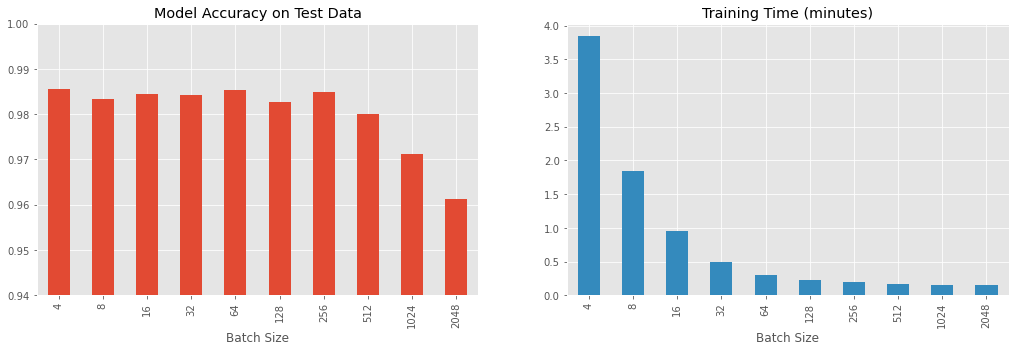

<Figure size 432x288 with 0 Axes>

In [55]:
ax=metrics[['TestAccuracy','TrainingTime']].plot(kind='bar',subplots=True,legend=False,figsize=(20,5),layout=(1,2));
ax[0,0].set_ylim([0.94, 1]);
ax[0,0].set_xlabel('Batch Size');
ax[0,0].set_title('Model Accuracy on Test Data');
ax[0,1].set_xlabel('Batch Size');
ax[0,1].set_title('Training Time (minutes)');
plt.subplots_adjust(right=0.8)
plt.show()

plt.savefig('BatchSize.png',bbox_inches='tight',format='png',dpi=100)

## MaxPool vs AvgPool

Building model
Starting model training
Finished model training in  0.23 (minutes)
Test Accuracy:  0.986299991607666


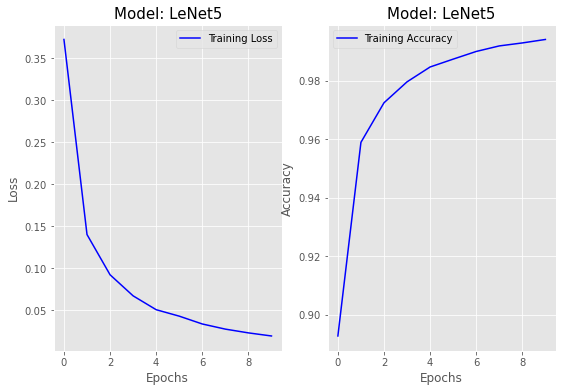

In [56]:
input_shape=train['features'][0].shape;
ActivationFunc='tanh';
Pooling='AvgPool';
Optimizer='adam';
epochs=10;
batch_size=128;
verbose=0;
modelName='LeNet5'
modelSaveName='LeNet5_Optimizer_'+Optimizer
saveFig=True
showfigs=True
save_path='C:\\Users\\Shaleen\\Documents\\Visual Studio 2019\\Semester Project\\LeNet-5'

_,metrics_LeNet5_adam_maxpool,_,_=ModelBuildTrain(input_shape, Nclasses,ActivationFunc,Pooling,Optimizer,\
                                    train,test,validation,epochs, batch_size,verbose,\
                                    modelName,modelSaveName,saveFig,save_path,showfigs)

In [57]:
pooling_methods=(metrics_LeNet5_adam_maxpool['TestAccuracy']-metrics_LeNet5_adam['TestAccuracy'])*100/metrics_LeNet5_adam['TestAccuracy']
print('MaxPool accuracy improvement over AvgPool: %',np.round(pooling_methods,1))

MaxPool accuracy improvement over AvgPool: % 0.1


In [59]:
acc=pd.DataFrame(index=['Avg Pooling','Max Pooling'],columns=['Testing Accuracy']);
acc.loc['Avg Pooling','Testing Accuracy']=metrics_LeNet5_adam['TestAccuracy']
acc.loc['Max Pooling','Testing Accuracy']=metrics_LeNet5_adam_maxpool['TestAccuracy']

In [61]:
heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]
acc.style.set_table_styles(dfstyle)

,Testing Accuracy
Avg Pooling,0.9855
Max Pooling,0.9863


# D) Effect of Activation Function

Building model
Starting model training
Finished model training in  0.24 (minutes)
Test Accuracy:  0.9866999983787537


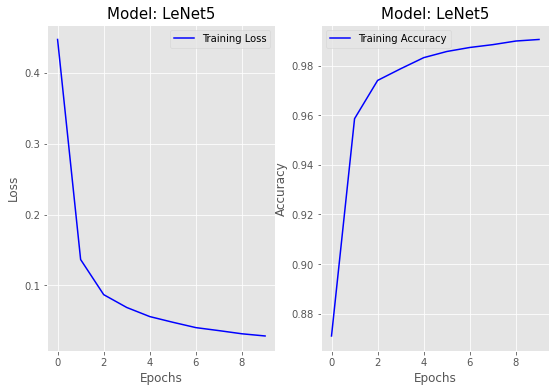

In [62]:
input_shape=train['features'][0].shape;
ActivationFunc='relu';
Pooling='AvgPool';
Optimizer='adam';
epochs=10;
batch_size=128;
verbose=0;
modelName='LeNet5'
modelSaveName='LeNet5_Optimizer_'+Optimizer
saveFig=True
showfigs=True
save_path='C:\\Users\\Shaleen\\Documents\\Visual Studio 2019\\Semester Project\\LeNet-5'

_,metrics_LeNet5_adam_relu,_,_=ModelBuildTrain(input_shape, Nclasses,ActivationFunc,Pooling,Optimizer,\
                                    train,test,validation,epochs, batch_size,verbose,\
                                    modelName,modelSaveName,saveFig,save_path,showfigs)

In [63]:
relu_methods=(metrics_LeNet5_adam_relu['TestAccuracy']-metrics_LeNet5_adam['TestAccuracy'])*100/metrics_LeNet5_adam['TestAccuracy']
print('Relu accuracy improvement over Tanh: %',np.round(relu_methods,1))

Relu accuracy improvement over Tanh: % 0.1


# E) Image Augmentation

### Horizontal Flipping

In [64]:
datagen = ImageDataGenerator(horizontal_flip=True)

In [65]:
test_augmented_filiped = datagen.flow(test['features'], test['labels'],shuffle=False ,batch_size=len(test['features'])).next()[0]

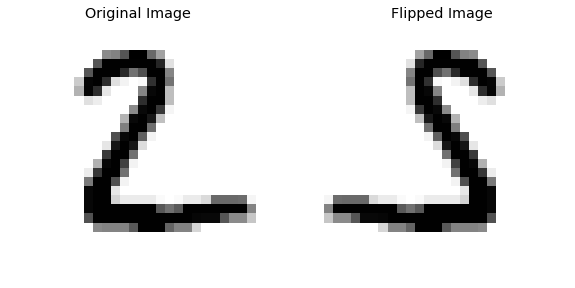

In [66]:
ImageNumber=1
fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2,figsize=(10,7))

ax1.imshow(test['features'][ImageNumber].squeeze(), cmap=plt.cm.gray_r)
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.set_title('Original Image');

ax2.imshow(test_augmented_filiped[ImageNumber].squeeze(), cmap=plt.cm.gray_r)
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_title('Flipped Image');
fig.savefig('Fliped.png',bbox_inches='tight',format='png',dpi=100)

In [67]:
confusion = confusion_matrix(test['labels'],\
                             np.argmax(LeNet5_adam.predict(test_augmented_filiped),axis=1),labels=list(np.arange(0,10)))

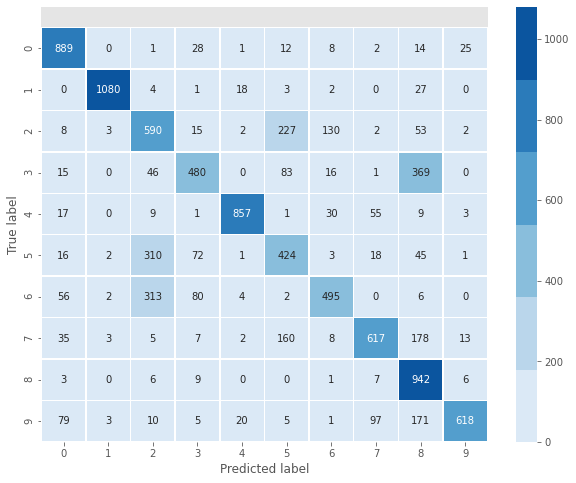

In [68]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(confusion, annot=True,ax=ax,fmt="d",linewidths=.5,cmap=sns.color_palette("Blues"));
plt.ylim([ 10,-0.5,]);
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('Confusion_Flipped.png',bbox_inches='tight',format='png',dpi=150)

In [69]:
_, testacc_hf = LeNet5_adam.evaluate(test_augmented_filiped, to_categorical(test['labels']), \
                                           batch_size=batch_size,verbose=verbose)

In [70]:
print('Test Accuracy on horizontally flipped images: ',np.round(testacc_hf,2))

Test Accuracy on horizontally flipped images:  0.7


In [71]:
acc=pd.DataFrame(index=['Base Model','Flipped Images'],columns=['Testing Accuracy']);
acc.loc['Base Model','Testing Accuracy']=metrics_LeNet5_adam['TestAccuracy']
acc.loc['Flipped Images','Testing Accuracy']=testacc_hf

In [72]:
heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]
dfstyle = [dict(selector="th", props=heading_properties),\
 dict(selector="td", props=cell_properties)]
acc.style.set_table_styles(dfstyle)

,Testing Accuracy
Base Model,0.9855
Flipped Images,0.6992


### Rotation

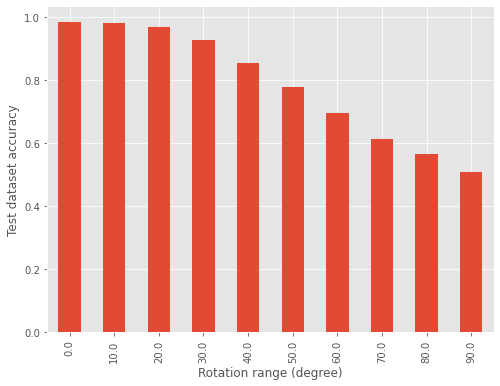

In [73]:
accuracy=pd.DataFrame(index=list(np.linspace(start=0,stop=90,num=10)),columns=['Test_Accuracy'])
for rrange in accuracy.index:
    datagen = ImageDataGenerator(horizontal_flip=False,rotation_range=rrange)
    tdata = datagen.flow(test['features'], test['labels'],shuffle=False ,batch_size=len(test['features'])).next()[0]
    _, ac = LeNet5_adam.evaluate(tdata, to_categorical(test['labels']), \
                                           batch_size=batch_size,verbose=verbose)
    accuracy.loc[rrange,'Test_Accuracy']=ac
accuracy.plot(kind='bar',figsize=(8,6),legend=False);
plt.xlabel('Rotation range (degree)');
plt.ylabel('Test dataset accuracy');
plt.savefig('Rotation.png',bbox_inches='tight',format='png',dpi=100)

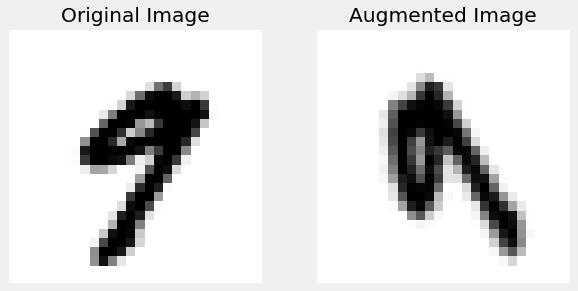

In [44]:
ImageNumber=20
fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2,figsize=(9,6))

ax1.imshow(test['features'][ImageNumber].squeeze(), cmap=plt.cm.gray_r)
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.set_title('Original Image');

ax2.imshow(tdata[ImageNumber].squeeze(), cmap=plt.cm.gray_r)
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_title('Augmented Image');
fig.savefig('Rotation_.png',bbox_inches='tight',format='png',dpi=100)

### Width Shift

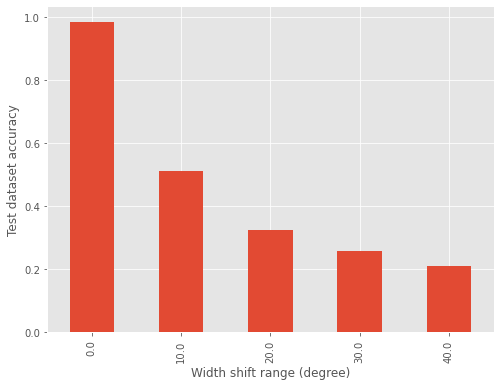

In [74]:
accuracy=pd.DataFrame(index=list(np.linspace(start=0,stop=40,num=5)),columns=['Test_Accuracy'])
for rrange in accuracy.index:
    datagen = ImageDataGenerator(horizontal_flip=False,width_shift_range=rrange,rotation_range=0)
    tdata = datagen.flow(test['features'], test['labels'],shuffle=False ,batch_size=len(test['features'])).next()[0]
    _, ac = LeNet5_adam.evaluate(tdata, to_categorical(test['labels']), \
                                           batch_size=batch_size,verbose=verbose)
    accuracy.loc[rrange,'Test_Accuracy']=ac
accuracy.plot(kind='bar',figsize=(8,6),legend=False);
plt.xlabel('Width shift range (degree)');
plt.ylabel('Test dataset accuracy');
plt.savefig('WidthShift.png',bbox_inches='tight',format='png',dpi=100)

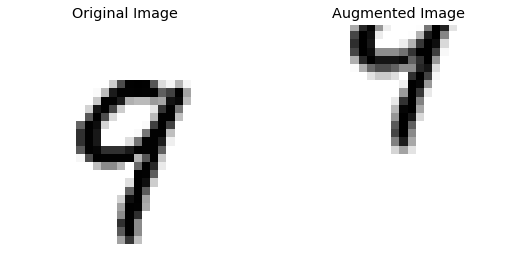

In [81]:
ImageNumber=12
fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2,figsize=(9,6))

ax1.imshow(test['features'][ImageNumber].squeeze(), cmap=plt.cm.gray_r)
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.set_title('Original Image');

ax2.imshow(tdata[ImageNumber].squeeze(), cmap=plt.cm.gray_r)
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_title('Augmented Image');
fig.savefig('WShift_.png',bbox_inches='tight',format='png',dpi=100)

### Height Shift

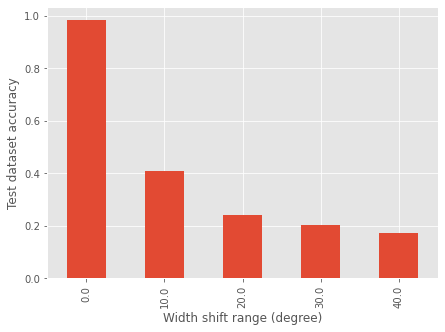

In [76]:
accuracy=pd.DataFrame(index=list(np.linspace(start=0,stop=40,num=5)),columns=['Test_Accuracy'])
for rrange in accuracy.index:
    datagen = ImageDataGenerator(horizontal_flip=False,height_shift_range=rrange,width_shift_range=0,rotation_range=0)
    tdata = datagen.flow(test['features'], test['labels'],shuffle=False ,batch_size=len(test['features'])).next()[0]
    _, ac = LeNet5_adam.evaluate(tdata, to_categorical(test['labels']), \
                                           batch_size=batch_size,verbose=verbose)
    accuracy.loc[rrange,'Test_Accuracy']=ac
accuracy.plot(kind='bar',figsize=(7,5),legend=False);
plt.xlabel('Width shift range (degree)');
plt.ylabel('Test dataset accuracy');

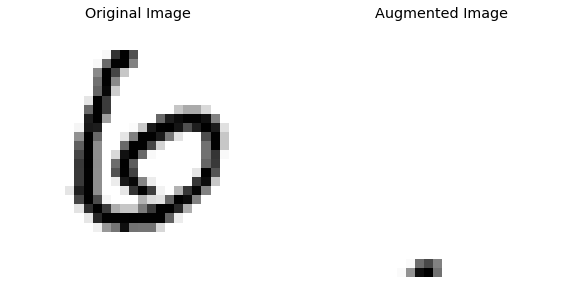

In [93]:
ImageNumber=11
fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2,figsize=(10,7))

ax1.imshow(test['features'][ImageNumber].squeeze(), cmap=plt.cm.gray_r)
ax1.xaxis.set_major_locator(plt.NullLocator())
ax1.yaxis.set_major_locator(plt.NullLocator())
ax1.set_title('Original Image');

ax2.imshow(tdata[ImageNumber].squeeze(), cmap=plt.cm.gray_r)
ax2.xaxis.set_major_locator(plt.NullLocator())
ax2.yaxis.set_major_locator(plt.NullLocator())
ax2.set_title('Augmented Image');

# F) Performance on CIFAR-10 Data set

In [4]:
from tensorflow.keras.datasets import cifar10

In [5]:
# CIFAR-10 Model
(input_train, output_train), (input_test, output_test) = cifar10.load_data()

In [6]:
# Input shape of CIFAR-10
input_train.shape

(50000, 32, 32, 3)

313/313 [==============================] - 2s 5ms/step - loss: 1.0356 - accuracy: 0.6496
Testset Loss: 1.035614
Testset Accuracy: 0.649600


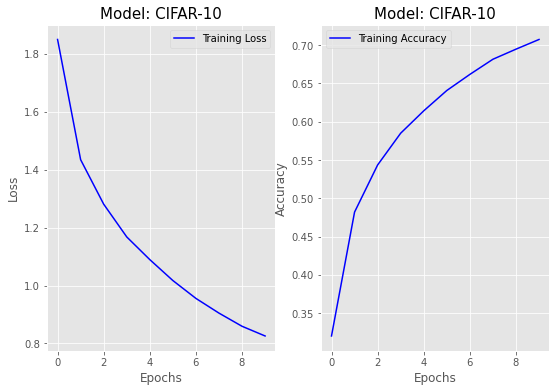

In [8]:

# Building Model
model = Sequential()
model.add(Conv2D(30, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(Conv2D(13, kernel_size=(3,3), padding='valid', activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(86, activation='relu'))
model.add(Dense(10, activation='softmax'))
# Compiling the model
model.compile(optimizer=optimizers.SGD(lr=0.01, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(input_train/255, to_categorical(output_train), epochs=10, batch_size=64,verbose=0)


# Evaluate the Model
score = model.evaluate(input_test/255, to_categorical(output_test), batch_size=32)
save_path='C:\\Users\\Shaleen\\Documents\\Visual Studio 2019\\Semester Project\\LeNet-5'
# print test set results
print("Testset Loss: %f" % score[0])
print("Testset Accuracy: %f" % score[1])
modelName='CIFAR-10'
# Plot the history
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch
fig, (ax1, ax2)=plt.subplots(nrows=1,ncols=2,figsize=(9,6))
# Loss
fig.subplots_adjust(hspace=0.5)
ax1.plot(hist['epoch'],hist['loss'],color='blue',label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Model: '+str(modelName),fontsize=15)
# Accuracy
ax2.plot(hist['epoch'],hist['accuracy'],color='blue',label='Training Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend();
ax2.set_title('Model: '+str(modelName),fontsize=15)
fig.savefig(save_path+'Learning_Curve_'+str('CIFAR_10')+'.png',bbox_inches='tight',format='png',dpi=300)

# Appendix (1) Layer Dimensions

<font size="5">$$n_{out}=[\dfrac{n_{in}+2p-k}{s}]+1$$</font> 

<font size="4">
    
* $n_{out}$  : output of ConvNet
* $n_{in}$   : Input image dimension
* $p$   : padding dimension
* $k$   : kernel dimension
* $s$   : strides size
</font> 


<font size="5">$$n_{param}=(n\times m \times l+1)\times f$$</font> 

<font size="4">
    
* $n_{param}$  : number of prameters
* $n$   : Kernel size dimension 1
* $m$   : Kernel size dimension 2
* $l$   : Input image
* $f$   : Filter size 
</font> 

# Appendix (2) Activation Functions

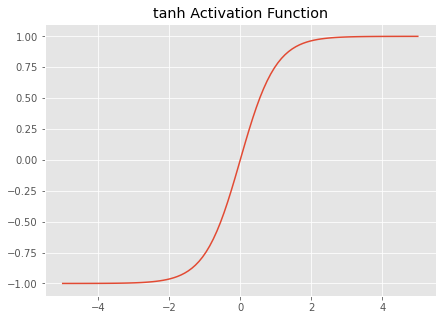

In [82]:
x=np.linspace(start=-5,stop =5,num=100)
y=(2/(1+np.exp(-2*x)))-1
plt.figure(figsize=(7,5))
plt.plot(x,y);
plt.title('tanh Activation Function');
plt.savefig('tanh.png',bbox_inches='tight',format='png',dpi=100)

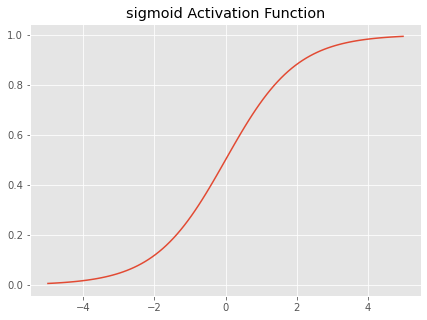

In [83]:
x=np.linspace(start=-5,stop =5,num=100)
y=1/(1+np.exp(-x))
plt.figure(figsize=(7,5))
plt.plot(x,y);
plt.title('sigmoid Activation Function');
plt.savefig('sigmoid.png',bbox_inches='tight',format='png',dpi=100)

In [17]:
x=np.arange(-2,5,0.1)
zero=np.zeros(len(z))

In [18]:
y=np.max([zero,x],axis=0)

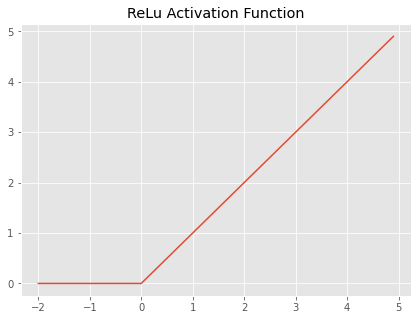

In [19]:
plt.figure(figsize=(7,5))
plt.plot(x,y);
plt.title('ReLu Activation Function');
#plt.savefig('sigmoid.png',bbox_inches='tight',format='png',dpi=100)